In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cross_validation
import io
import skyplot as sp
import missingno as msno

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

As there is a difference of one column which is nothing but a target field which is not there in test dataset.

In [3]:
# train['SalePrice'] = np.log(train['SalePrice'])

In [4]:
print('Train Shape: ',train.shape)
print('Test  Shape: ',test.shape)

Train Shape:  (1460, 81)
Test  Shape:  (1459, 80)


In [5]:
print("# Numerical Features: ",len(train.select_dtypes(include=[np.number]).columns))
print("# Categorical Features: ",len(train.select_dtypes(exclude=[np.number]).columns))

# Numerical Features:  38
# Categorical Features:  43


## Missing Values

In [6]:
nullcols = train.columns[train.isnull().any()]

In [7]:
(train[train.columns[train.isnull().sum()>0]].isnull().sum()/len(train)*100).sort_values(ascending=False)

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageYrBlt      5.547945
GarageType       5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtFinType2     2.602740
BsmtExposure     2.602740
BsmtFinType1     2.534247
BsmtCond         2.534247
BsmtQual         2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
dtype: float64

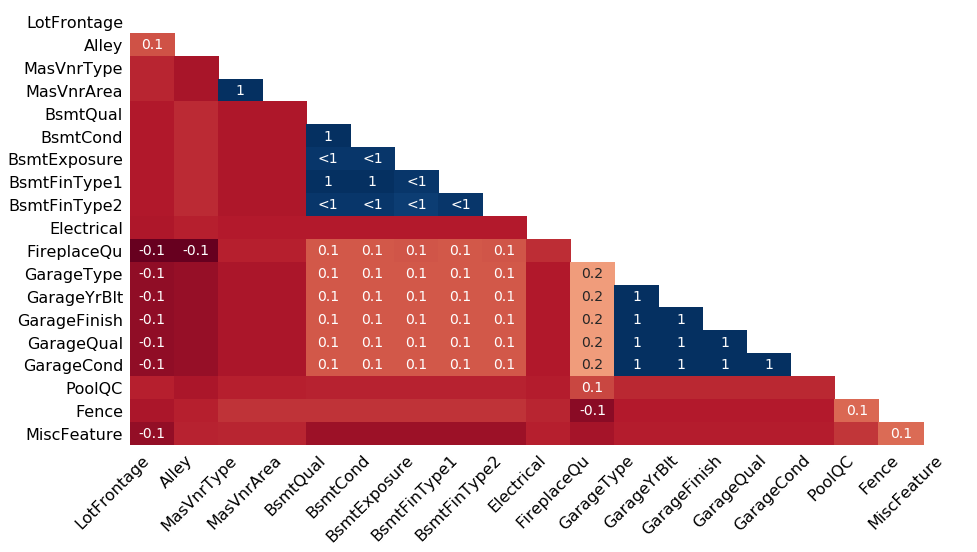

In [8]:
msno.heatmap(train, figsize=(15,8))

#### Checking PoolQC Feature

PoolQC got 99% data missing

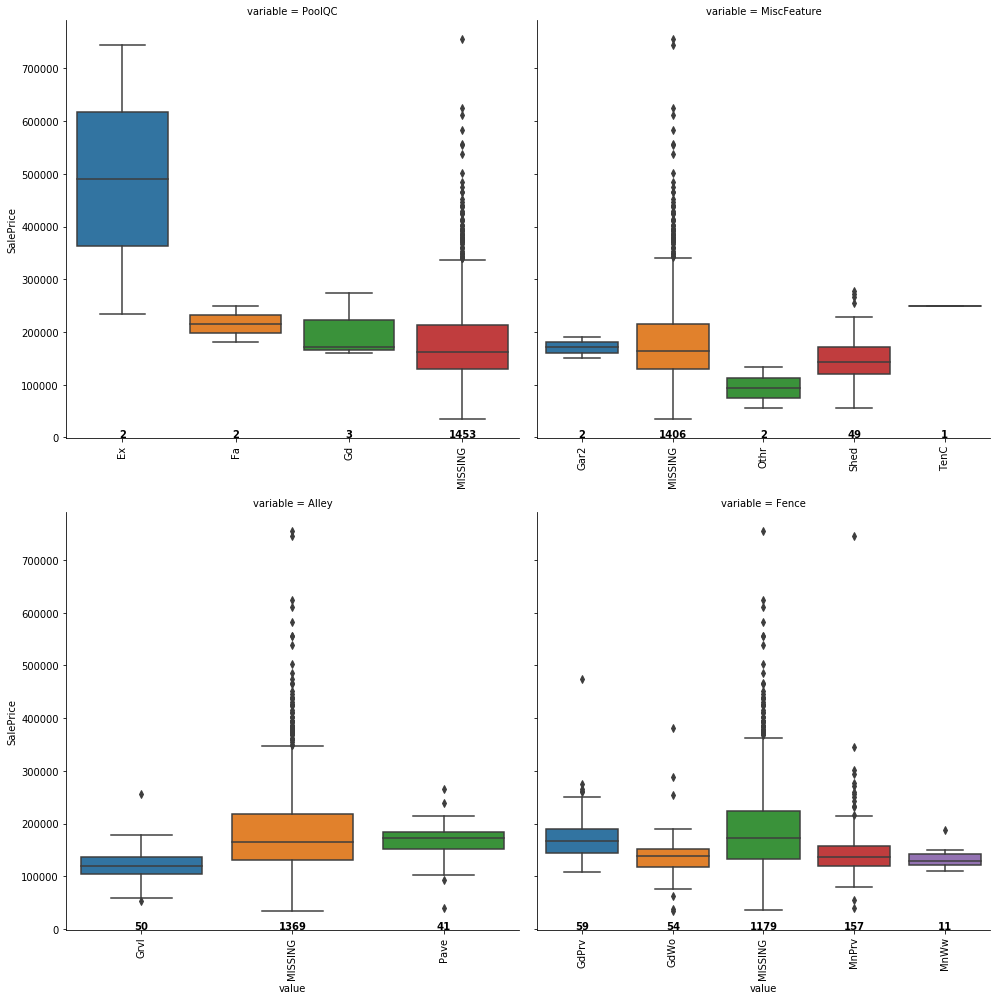

In [9]:
sp.boxplot(['PoolQC','MiscFeature','Alley','Fence'], 'SalePrice', train)

In [10]:
# As we can see, there is no need to include 'PoolQC','MiscFeature','Alley','Fence' as of now.
train.drop(['PoolQC','MiscFeature','Alley','Fence'], inplace=True, axis=1)

##### FireplaceQu

As you're seeing, [Ex, Gd and TA] seems to have higher sales price than of [Po, Fa and Missing] ones. So we can club into two categories 1 (For Good) and 0(For Bad).

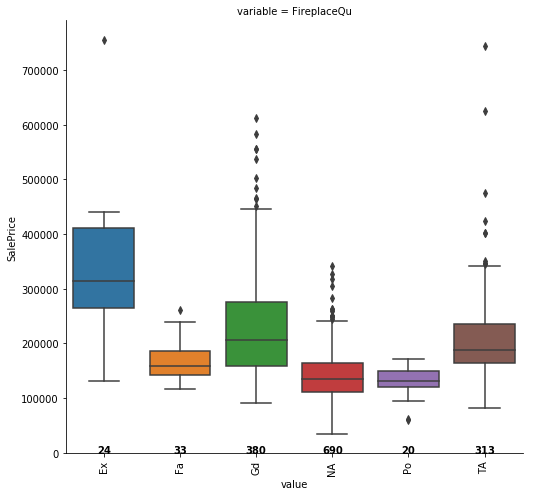

In [11]:
train.FireplaceQu.fillna('NA', inplace=True)
sp.boxplot(['FireplaceQu'], 'SalePrice', train,'count',False)

In [12]:
pd.crosstab(train.FireplaceQu, train.Fireplaces, train.Id, aggfunc='count')

Fireplaces,0,1,2,3
FireplaceQu,,,,
Ex,NaN,19.0,4.0,1.0
Fa,NaN,28.0,4.0,1.0
Gd,NaN,324.0,54.0,2.0
NA,690.0,NaN,NaN,NaN
Po,NaN,20.0,NaN,NaN
TA,NaN,259.0,53.0,1.0


In [13]:
train['n_FireplaceQu']=train.FireplaceQu.apply(func=lambda x: 1 if x in ['Ex', 'TA', 'Gd'] else 0)

In [14]:
train[['n_FireplaceQu', 'FireplaceQu']].head()

,n_FireplaceQu,FireplaceQu
0,0,NA
1,1,TA
2,1,TA
3,1,Gd
4,1,TA


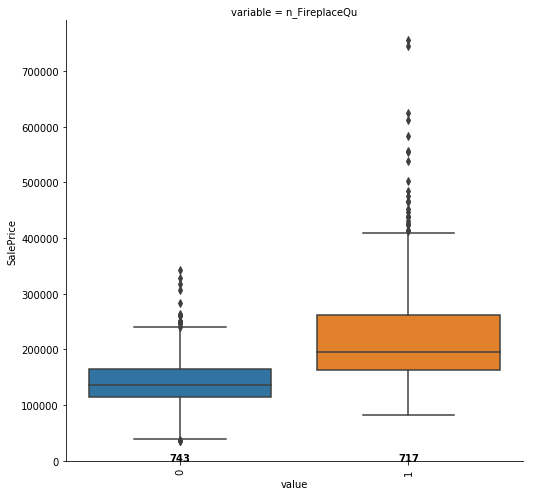

In [15]:
sp.boxplot('n_FireplaceQu', 'SalePrice', train)

##### LotFrontage

LotArea Correlation for a subset: 
             LotArea  SalePrice
LotArea    1.000000   0.257957
SalePrice  0.257957   1.000000

LotArea for all set: 
             LotArea  SalePrice
LotArea    1.000000   0.263843
SalePrice  0.263843   1.000000

LotFrontage for all set: 
              LotFrontage  SalePrice
LotFrontage     1.000000   0.351799
SalePrice       0.351799   1.000000


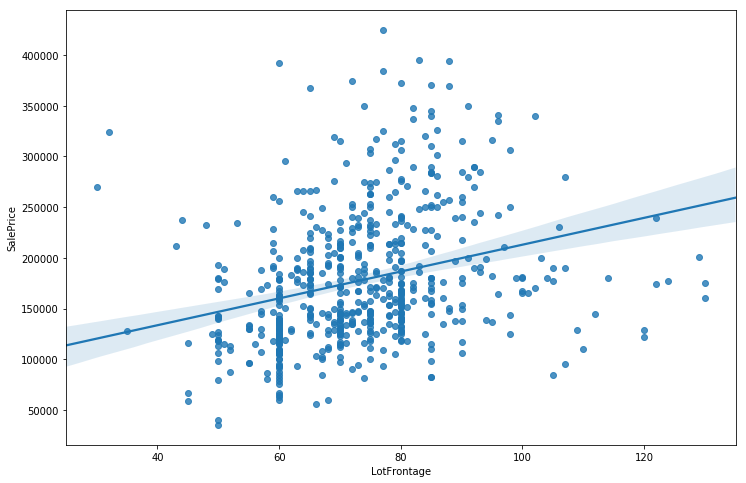

In [16]:
print('LotArea Correlation for a subset: \n',train[(train.LotArea<12000) & (train.LotArea>8000)][['LotArea','SalePrice']].corr())
print('\nLotArea for all set: \n',train[['LotArea','SalePrice']].corr())
print('\nLotFrontage for all set: \n',train[['LotFrontage','SalePrice']].corr())
plt.figure(figsize=(12,8))
sns.regplot('LotFrontage','SalePrice',train[(train.LotArea<12000) & (train.LotArea>8000)])
plt.show()


             LotFrontage   LotArea
LotFrontage     1.000000  0.729225
LotArea         0.729225  1.000000


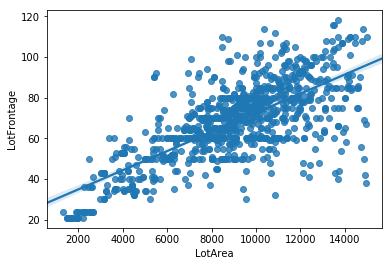

In [17]:
print(train[(train.LotFrontage<120) & (train.LotArea<15000)][['LotFrontage','LotArea']].corr())
sns.regplot('LotArea','LotFrontage',train[(train.LotFrontage<120) & (train.LotArea<15000)])

In [18]:
data = train.copy()
data['IsNullLotFront'] = data.LotFrontage.isnull()

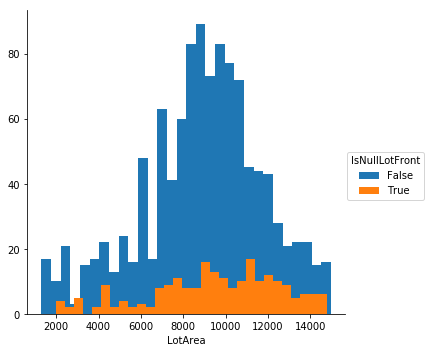

In [19]:
g = sns.FacetGrid(data[data.LotArea<15000], hue='IsNullLotFront', sharex=True, sharey=True, size=5)
g.map(plt.hist,'LotArea', bins=30).add_legend()

# plt.show()
# print(g.map(sns.regplot, 'LotArea', 'SalePrice').add_legend())

In [20]:
x = data[data['IsNullLotFront']==False]['LotArea'].values.reshape(-1,1)
y = data[data['IsNullLotFront']==False]['LotFrontage'].values.reshape(-1,1)
z = data[data['IsNullLotFront']==True]['LotArea'].values.reshape(-1,1)
regr = LinearRegression()
regr.fit(x, y)
# data[data['IsNullLotFront']==True].LotArea
# np.concatenate(y, regr.predict(z))
# np.concatenate((y.T, regr.predict(z).round(0).T))


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [21]:
np.concatenate((y, regr.predict(z).round()))

array([[ 65.],
       [ 80.],
       [ 68.],
       ..., 
       [ 63.],
       [ 69.],
       [ 91.]])

In [22]:
a = np.concatenate((np.array(data[data['IsNullLotFront']==True].index).reshape(-1,1), regr.predict(z).round()), axis=1)

In [23]:
x = pd.DataFrame(a)
del(a)

In [24]:
x.columns = ['index', 'missingLotFrontage']

In [25]:
x.set_index('index', inplace=True)

In [26]:
data = pd.merge(data, x, how='left', left_index=True, right_index=True)

In [27]:
data['LotFrontage'].fillna(0, inplace=True)
data.missingLotFrontage.fillna(0, inplace=True)
data['LotFrontage'] = data['LotFrontage'] + data.missingLotFrontage

In [28]:
train['LotFrontage'] = data['LotFrontage']

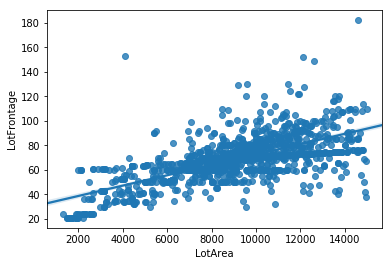

In [29]:
sns.regplot('LotArea', 'LotFrontage', train[train['LotArea']<15000])

In [30]:
train[train['LotArea']<15000][['LotFrontage', 'SalePrice']].corr()

,LotFrontage,SalePrice
LotFrontage,1.000000,0.374748
SalePrice,0.374748,1.000000


##### GarageType

In [31]:
# 'NA' defines garage is not available 
train.GarageType.fillna('NA', inplace=True)

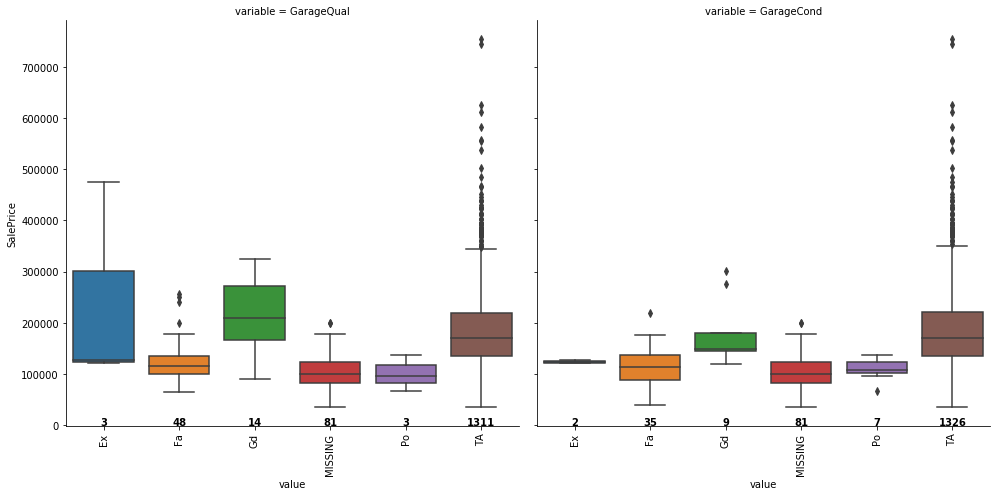

In [32]:
sp.boxplot(['GarageQual','GarageCond'],'SalePrice', train)

In [33]:
train.GarageCond.fillna('NA', inplace=True)
train.GarageQual.fillna('NA', inplace=True)
pd.crosstab(train.GarageCond,train.GarageQual, train.Id, aggfunc='count', dropna=False)

GarageQual,Ex,Fa,Gd,NA,Po,TA
GarageCond,,,,,,
Ex,2.0,NaN,NaN,NaN,NaN,NaN
Fa,NaN,20.0,NaN,NaN,NaN,15.0
Gd,NaN,NaN,4.0,NaN,NaN,5.0
NA,NaN,NaN,NaN,81.0,NaN,NaN
Po,NaN,4.0,NaN,NaN,3.0,NaN
TA,1.0,24.0,10.0,NaN,NaN,1291.0


As we can see, GarageQual and GarageCond seems same. GarageCond would be better to consider, because it states the current or actual condition of the garage

In [34]:
train['n_GarageCond'] = train.GarageCond.apply(lambda x: 1 if x in ['Ex','Gd','TA'] else 0)

In [35]:
pd.crosstab(train.n_GarageCond,train.GarageType, train.Id, aggfunc='count', dropna=False)

GarageType,2Types,Attchd,Basment,BuiltIn,CarPort,Detchd,NA
n_GarageCond,,,,,,,
0,1.0,2.0,NaN,NaN,1.0,38.0,81.0
1,5.0,868.0,19.0,88.0,8.0,349.0,NaN


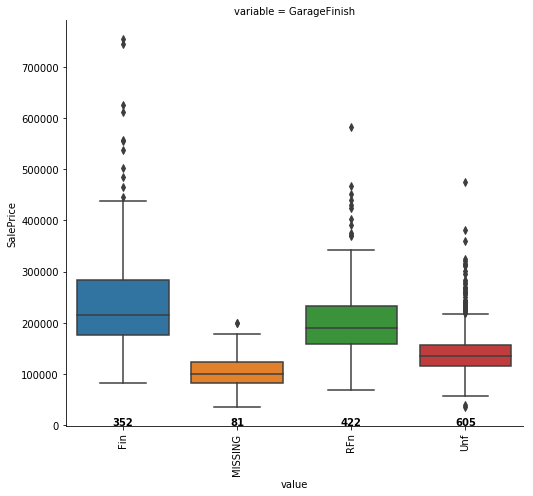

In [36]:
sp.boxplot('GarageFinish', 'SalePrice', train)

#### As we can see, garageFinish doesnot have much impact on SalePrice. We can drop as of now.

In [37]:
train.drop('GarageFinish', inplace=True, axis=1)

##### Remaining Missing Values

In [38]:
print(train.columns[train.isnull().any()].values)

['MasVnrType' 'MasVnrArea' 'BsmtQual' 'BsmtCond' 'BsmtExposure'
 'BsmtFinType1' 'BsmtFinType2' 'Electrical' 'GarageYrBlt']



####  Basement Variables

In [39]:
[i for i in train.columns if i.startswith('Bsmt')]

['BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'BsmtFullBath',
 'BsmtHalfBath']

In [40]:
# Filling al basement variables with NA
# train.BsmtCond.fillna('NA')
for i in ['BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtQual']:
    train[i].fillna('NA', inplace=True)

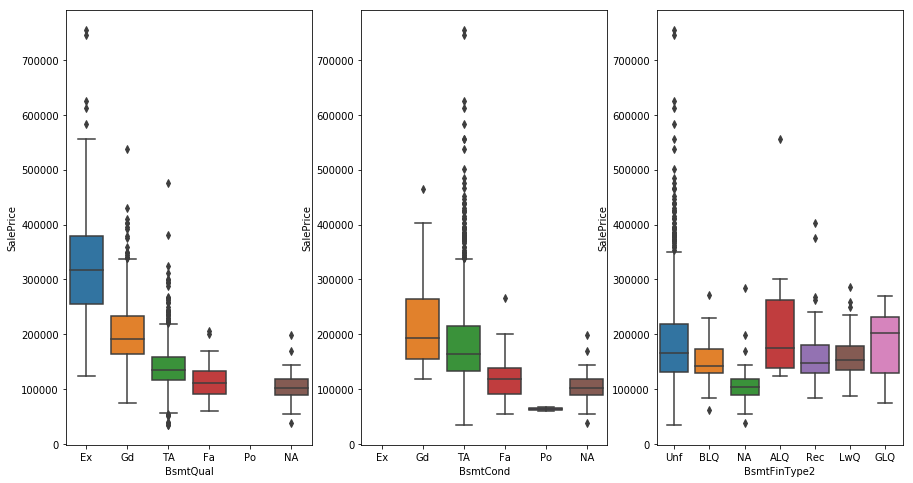

In [41]:
fig, ax  = plt.subplots(1,3, figsize = (15,8))
axis = []
for i in fig.axes:
    axis.append(i)
sns.boxplot('BsmtQual', 'SalePrice', data=train, order=['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'], ax=axis[0])
sns.boxplot('BsmtCond', 'SalePrice', data=train, order=['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'], ax=axis[1])
sns.boxplot('BsmtFinType2', 'SalePrice', data=train, ax=axis[2])

In [42]:
# RatingMapping = pd.DataFrame.from_dict(
RatingMapping = {'Ex':1, 'Gd':2, 'TA':3, 'Fa':4, 'Po':5, 'NA':6}
print(pd.crosstab(train['BsmtQual'],train['BsmtCond'], train['Id'], aggfunc='count'))
# RatingMapping.index.names = ['index']
# RatingMapping.columns.name = 'Rating','ABC'
# train.BsmtQual.replace(RatingMapping)
# pd.merge(data, RatingMapping, left_on='BsmtQual', right_index=True)
# data[['n_BsmtQual', 'BsmtQual']]
data = train.copy()
data['Bsmt'] = train.BsmtQual.replace(RatingMapping)*10 + train.BsmtCond.replace(RatingMapping)
data['Bsmttext'] = train.BsmtQual + train.BsmtCond

BsmtCond    Fa    Gd    NA   Po     TA
BsmtQual                              
Ex         NaN  11.0   NaN  NaN  110.0
Fa         8.0   NaN   NaN  2.0   25.0
Gd         2.0  36.0   NaN  NaN  580.0
NA         NaN   NaN  37.0  NaN    NaN
TA        35.0  18.0   NaN  NaN  596.0


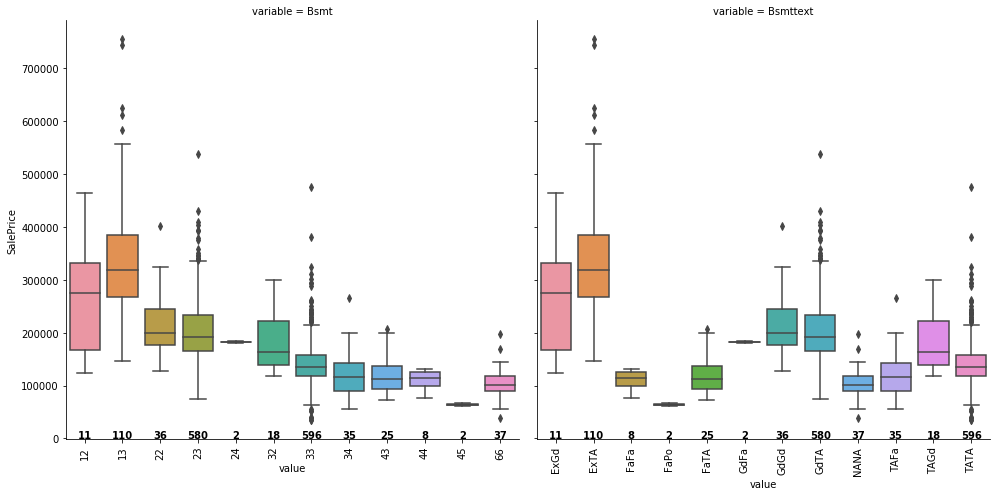

In [43]:
sp.boxplot(['Bsmt','Bsmttext'], 'SalePrice', data)

             TotalBsmtSF  SalePrice
TotalBsmtSF     1.000000   0.605018
SalePrice       0.605018   1.000000


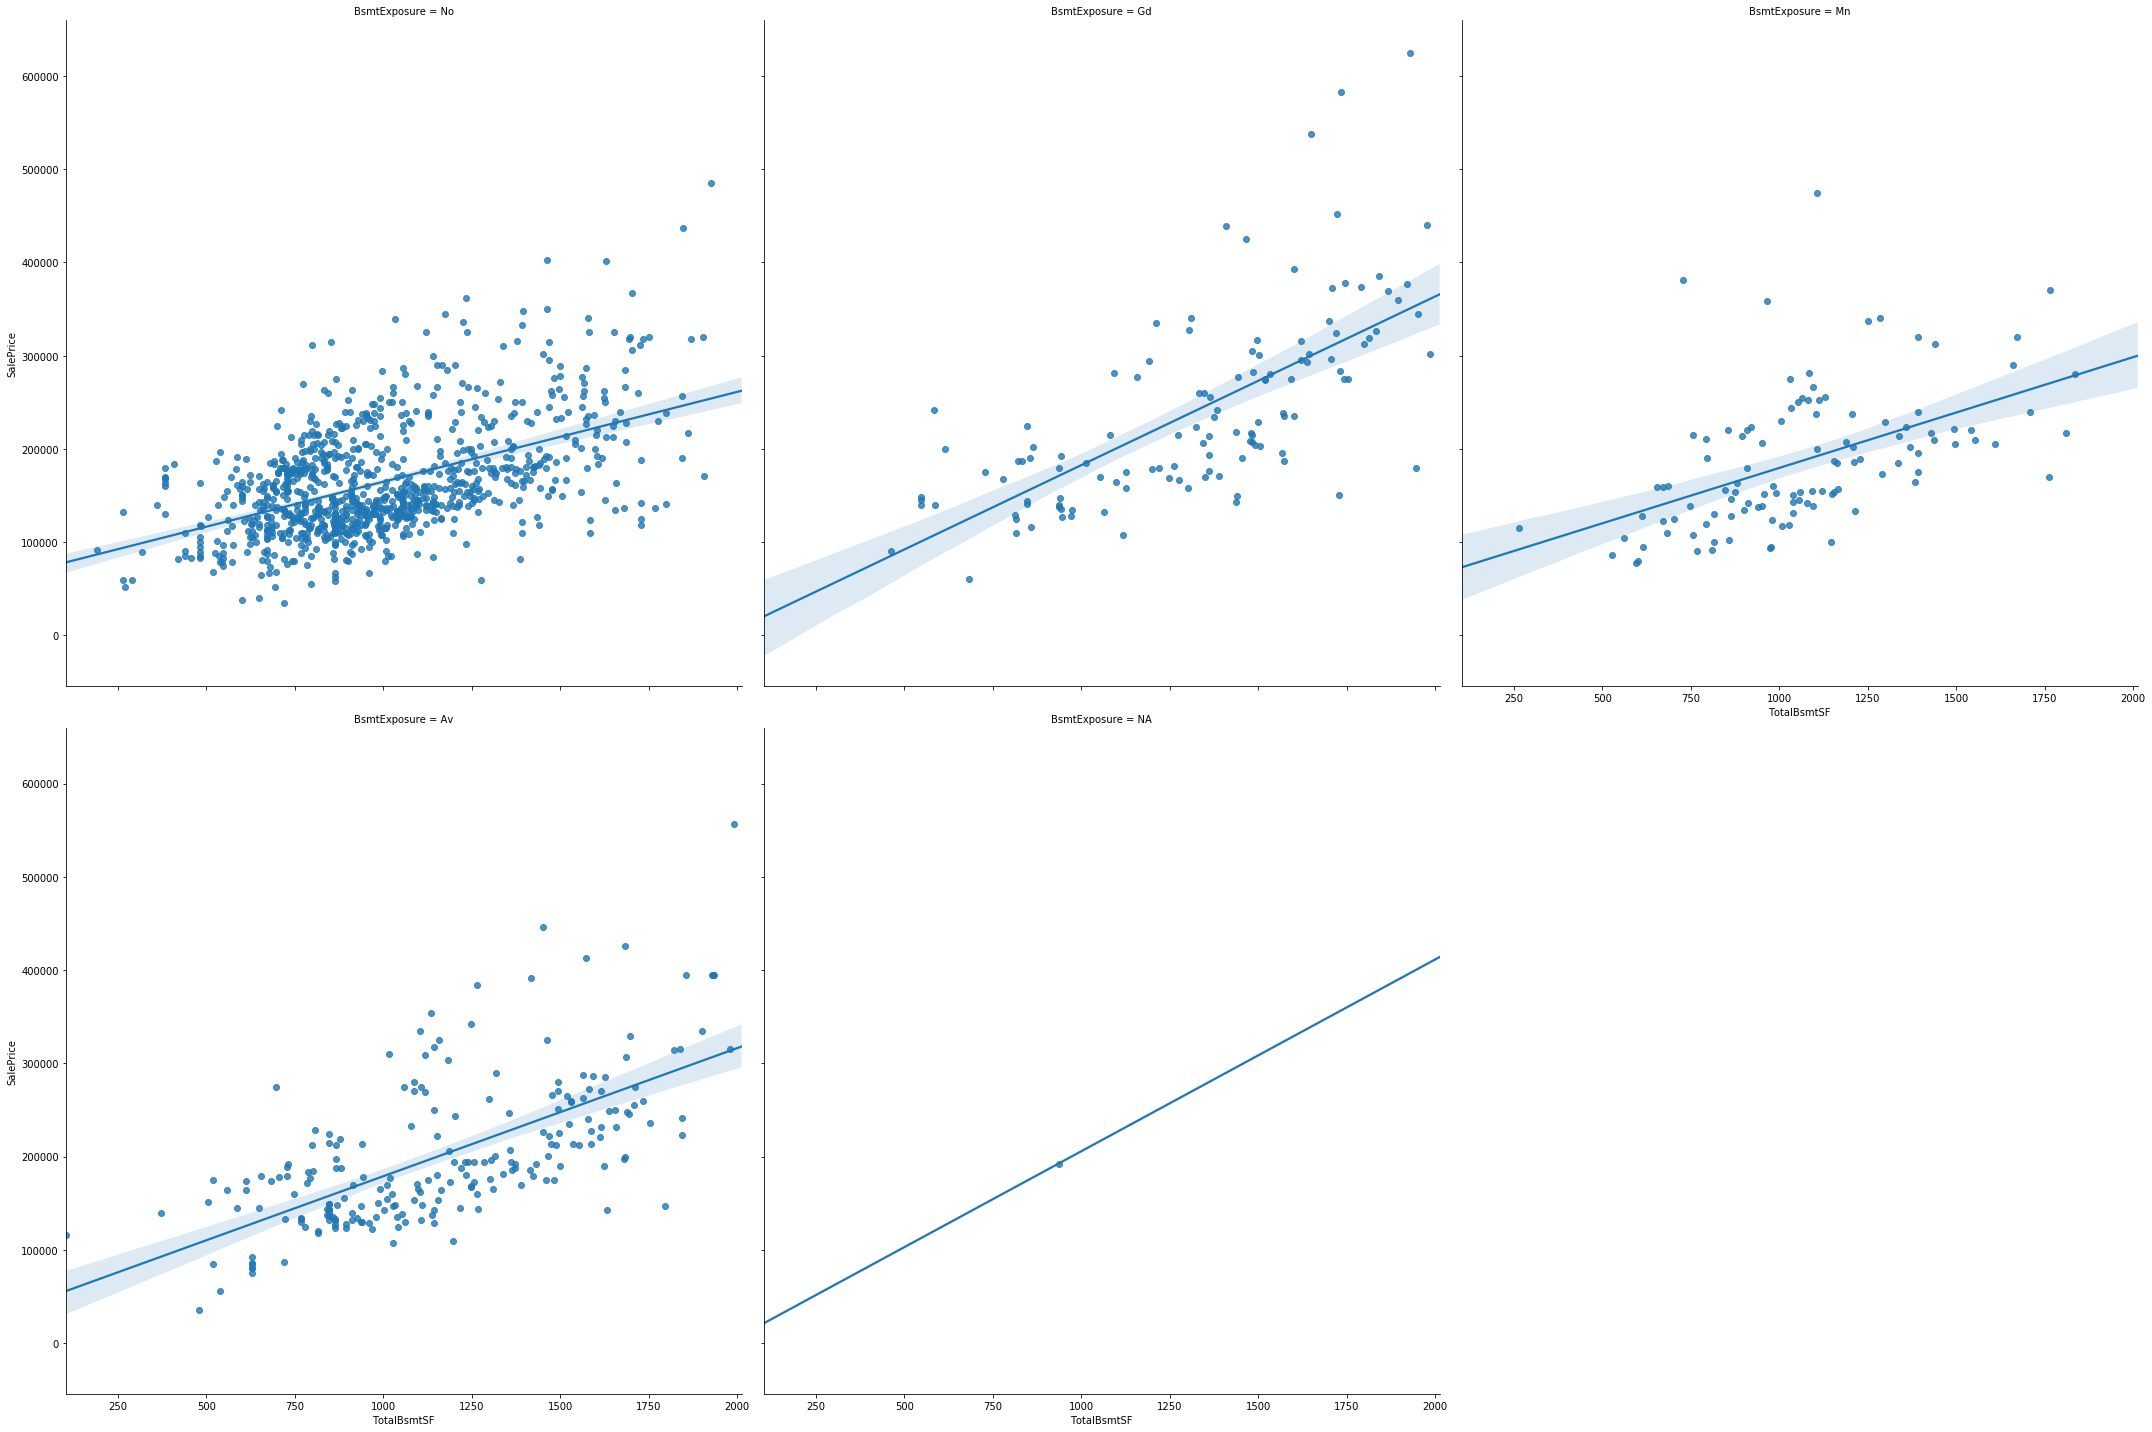

In [44]:
print(data[(data.TotalBsmtSF<2000) & (data.TotalBsmtSF>0)][['TotalBsmtSF', 'SalePrice']].corr())
# %matplotlib notebook

t = sns.FacetGrid(data[(data.TotalBsmtSF<2000) & (data.TotalBsmtSF>0)],col='BsmtExposure',col_wrap=3, sharex=True, sharey=True, size=10)
t.map(sns.regplot, 'TotalBsmtSF',"SalePrice")

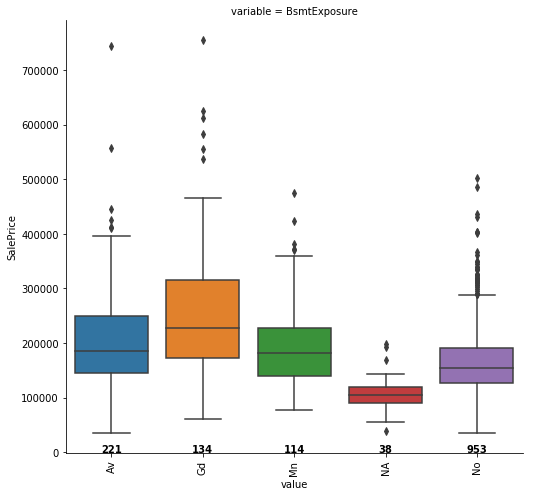

In [45]:
sp.boxplot('BsmtExposure', 'SalePrice', data)

`BsmtExposure` doesnot make much impact on target variable. Lets delete this for now.

In [46]:
train.drop('BsmtExposure', axis=1, inplace=True)

In [47]:
RatingMapping = {'Ex':1, 'Gd':2, 'TA':3, 'Fa':4, 'Po':5, 'NA':6}
data['Bsmt'] = train.BsmtQual.replace(RatingMapping)*10 + train.BsmtCond.replace(RatingMapping)
train['n_BsmtQua'] = data.Bsmt.apply(lambda x: 3 if x < 20 else(2 if x < 33 else 1) )

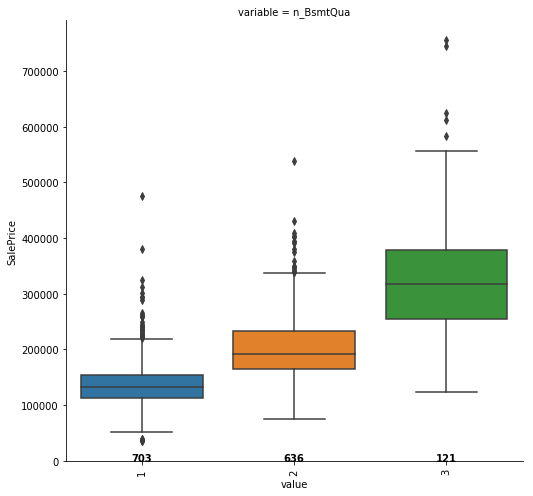

In [48]:
sp.boxplot('n_BsmtQua', 'SalePrice', train)

#### GarageYrBuilt Missing Imputation

             GarageYrBlt  YearBuilt  SalePrice
GarageYrBlt     1.000000   0.825667   0.486362
YearBuilt       0.825667   1.000000   0.522897
SalePrice       0.486362   0.522897   1.000000


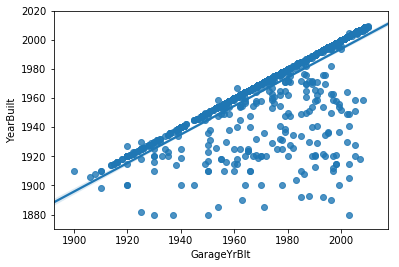

In [49]:
print(train[['GarageYrBlt', 'YearBuilt','SalePrice']].corr())
sns.regplot('GarageYrBlt', 'YearBuilt', train)

In [50]:
train.GarageYrBlt.isnull().sum()

81

Those houses which donot have any garage, their GarageYrBlt is missing. 

In [51]:
# Missing Columns
print(train.columns[train.isnull().any()].values)

['MasVnrType' 'MasVnrArea' 'Electrical' 'GarageYrBlt']


### Electrical, MasVnr* Feature

In [52]:
# Electrical doesnot making much impact, dropping this field too.
train.drop(['Electrical', 'MasVnrType', 'MasVnrArea'], 1, inplace=True)

### Checking if any column exists with NULL values

In [53]:
train.columns[train.isnull().any()]

Index(['GarageYrBlt'], dtype='object')

In [54]:
# ignore GarageYrBlt as of now

In [55]:
print((train.isnull().sum().sort_values(ascending=False)[:2]))
print((train.isnull().sum()/len(train)*100).round(2).sort_values(ascending=False)[:2])

GarageYrBlt    81
Foundation      0
dtype: int64
GarageYrBlt    5.55
Foundation     0.00
dtype: float64


In [56]:
train.drop(['GarageYrBlt'], 1, inplace=True)

In [57]:
train.columns[train.isnull().any()]

Index([], dtype='object')

### Dividing data into numerical and categorical features

In [58]:
# All features except of number dtype will considered as categorical features
catfeatures = train.select_dtypes(exclude=[np.number]).copy()

# All features of type number
numfeatures = train.select_dtypes(include=[np.number]).copy()

numfeatures.drop(['Id','MSSubClass'],axis=1,inplace=True)

catfeatures['MSSubClass'] = train['MSSubClass']

## <br>Numerical Features

In [59]:
numfeatures.columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'n_FireplaceQu',
       'n_GarageCond', 'n_BsmtQua'],
      dtype='object')

Lets see how many missing values are there in the data

#### Highly correlated features

Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF',
       'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
       'GarageArea', 'n_FireplaceQu', 'n_BsmtQua'],
      dtype='object')

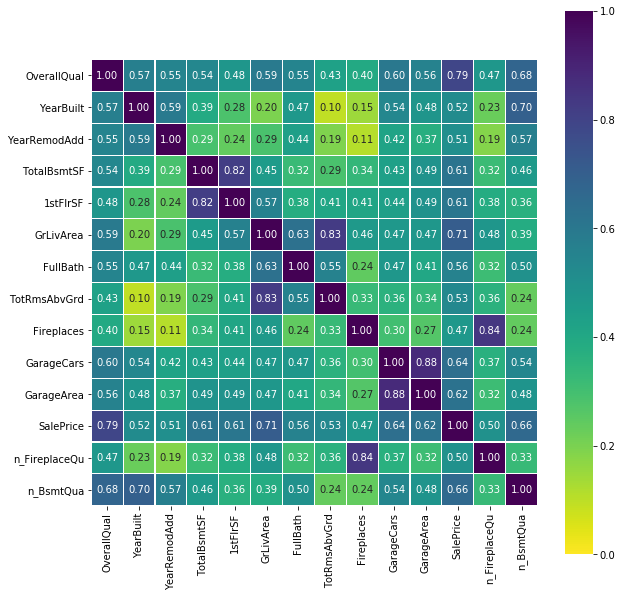

In [60]:
corr = numfeatures.corr()

#Highly Correlated Features
numfeatures_high_corr = corr[corr.index[(corr['SalePrice']>0.40) | (corr['SalePrice']<-0.4)]].loc[
    corr.index[(corr['SalePrice']>0.40) | (corr['SalePrice']<-0.4)]]

# Heatmap 
plt.figure(figsize=(10,10))
sns.heatmap(numfeatures_high_corr,annot=True,fmt='.2f', 
            vmax=1.0, vmin=0.0,cmap='viridis_r',square=True,annot_kws={"size":10},linewidths=0.1)

highly_corr_features = numfeatures_high_corr.drop('SalePrice').index
del(numfeatures_high_corr)
highly_corr_features

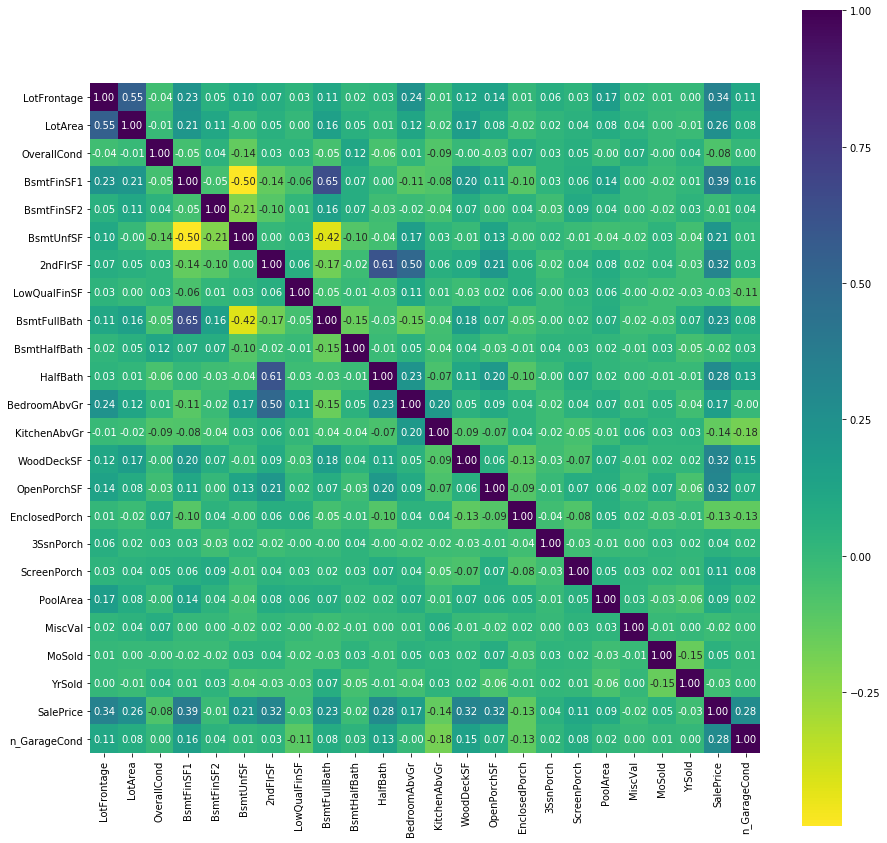

Low Corr Related Features: 
 ['LotFrontage', 'LotArea', 'OverallCond', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'n_GarageCond']


In [61]:
plt.figure(figsize = (15,15))
sns.heatmap(numfeatures.drop(highly_corr_features, axis=1).corr(), annot=True, fmt='.2f', square=True, cmap='viridis_r')
plt.show() 
low_corr_features = numfeatures.drop(highly_corr_features, axis=1).columns
print('Low Corr Related Features: \n',low_corr_features.tolist())

Its not necessary that if the correlation of columns with target variable is low, it doesnot have any impact. Let see if we can find some insight out of them.

##### Checking the RMSE for the highly correlated variables

In [62]:
highly_corr_features

Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF',
       'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
       'GarageArea', 'n_FireplaceQu', 'n_BsmtQua'],
      dtype='object')

##### Now lets tune those variables and new ones, then we'll see if we can increase its performance

In [68]:
print('Highly Correlated Features: \n',highly_corr_features)
print('\nAll Num Features: \n', numfeatures.columns)

Highly Correlated Features: 
 Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF',
       'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
       'GarageArea', 'n_FireplaceQu', 'n_BsmtQua'],
      dtype='object')

All Num Features: 
 Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'n_FireplaceQu',
       'n_GarageCond', 'n_BsmtQua'],
      dtype='object')


           HouseAge  SalePrice
HouseAge    1.00000   -0.52335
SalePrice  -0.52335    1.00000
           ActualAge  SalePrice
ActualAge   1.000000  -0.523063
SalePrice  -0.523063   1.000000
           HouseAge  ActualAge
HouseAge   1.000000   0.999972
ActualAge  0.999972   1.000000


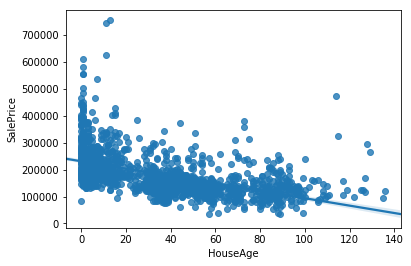

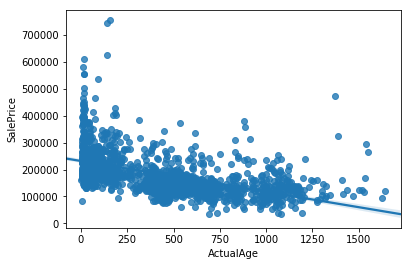

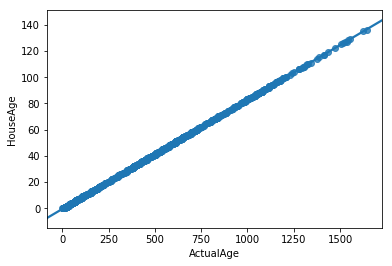

In [69]:
df = train.copy()
df['HouseAge'] = df['YrSold'] - df['YearBuilt']
df['MoYrSold'] = df['YrSold']*12 + df['MoSold']
df['ActualAge'] = df['MoYrSold'] - df['YearBuilt']*12
print(df[['HouseAge', 'SalePrice']].corr())
print(df[['ActualAge', 'SalePrice']].corr())
print(df[['HouseAge', 'ActualAge']].corr())
sns.regplot('HouseAge', 'SalePrice', df)
plt.figure()
sns.regplot('ActualAge', 'SalePrice', df)
plt.figure()
sns.regplot('ActualAge', 'HouseAge', df)

In [70]:
print(df[['ActualAge', 'SalePrice']].corr())

           ActualAge  SalePrice
ActualAge   1.000000  -0.523063
SalePrice  -0.523063   1.000000


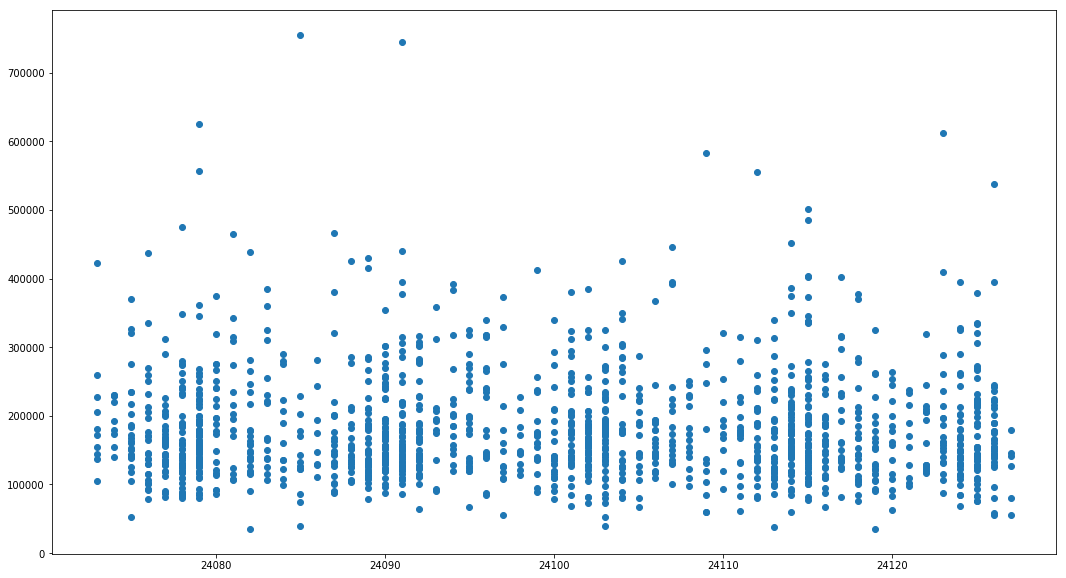

In [71]:
df.sort_values('MoYrSold', inplace=True)
plt.figure(figsize=(18,10))
plt.plot(df.MoYrSold, df.SalePrice, 'o')

In [72]:
df.MoSold.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

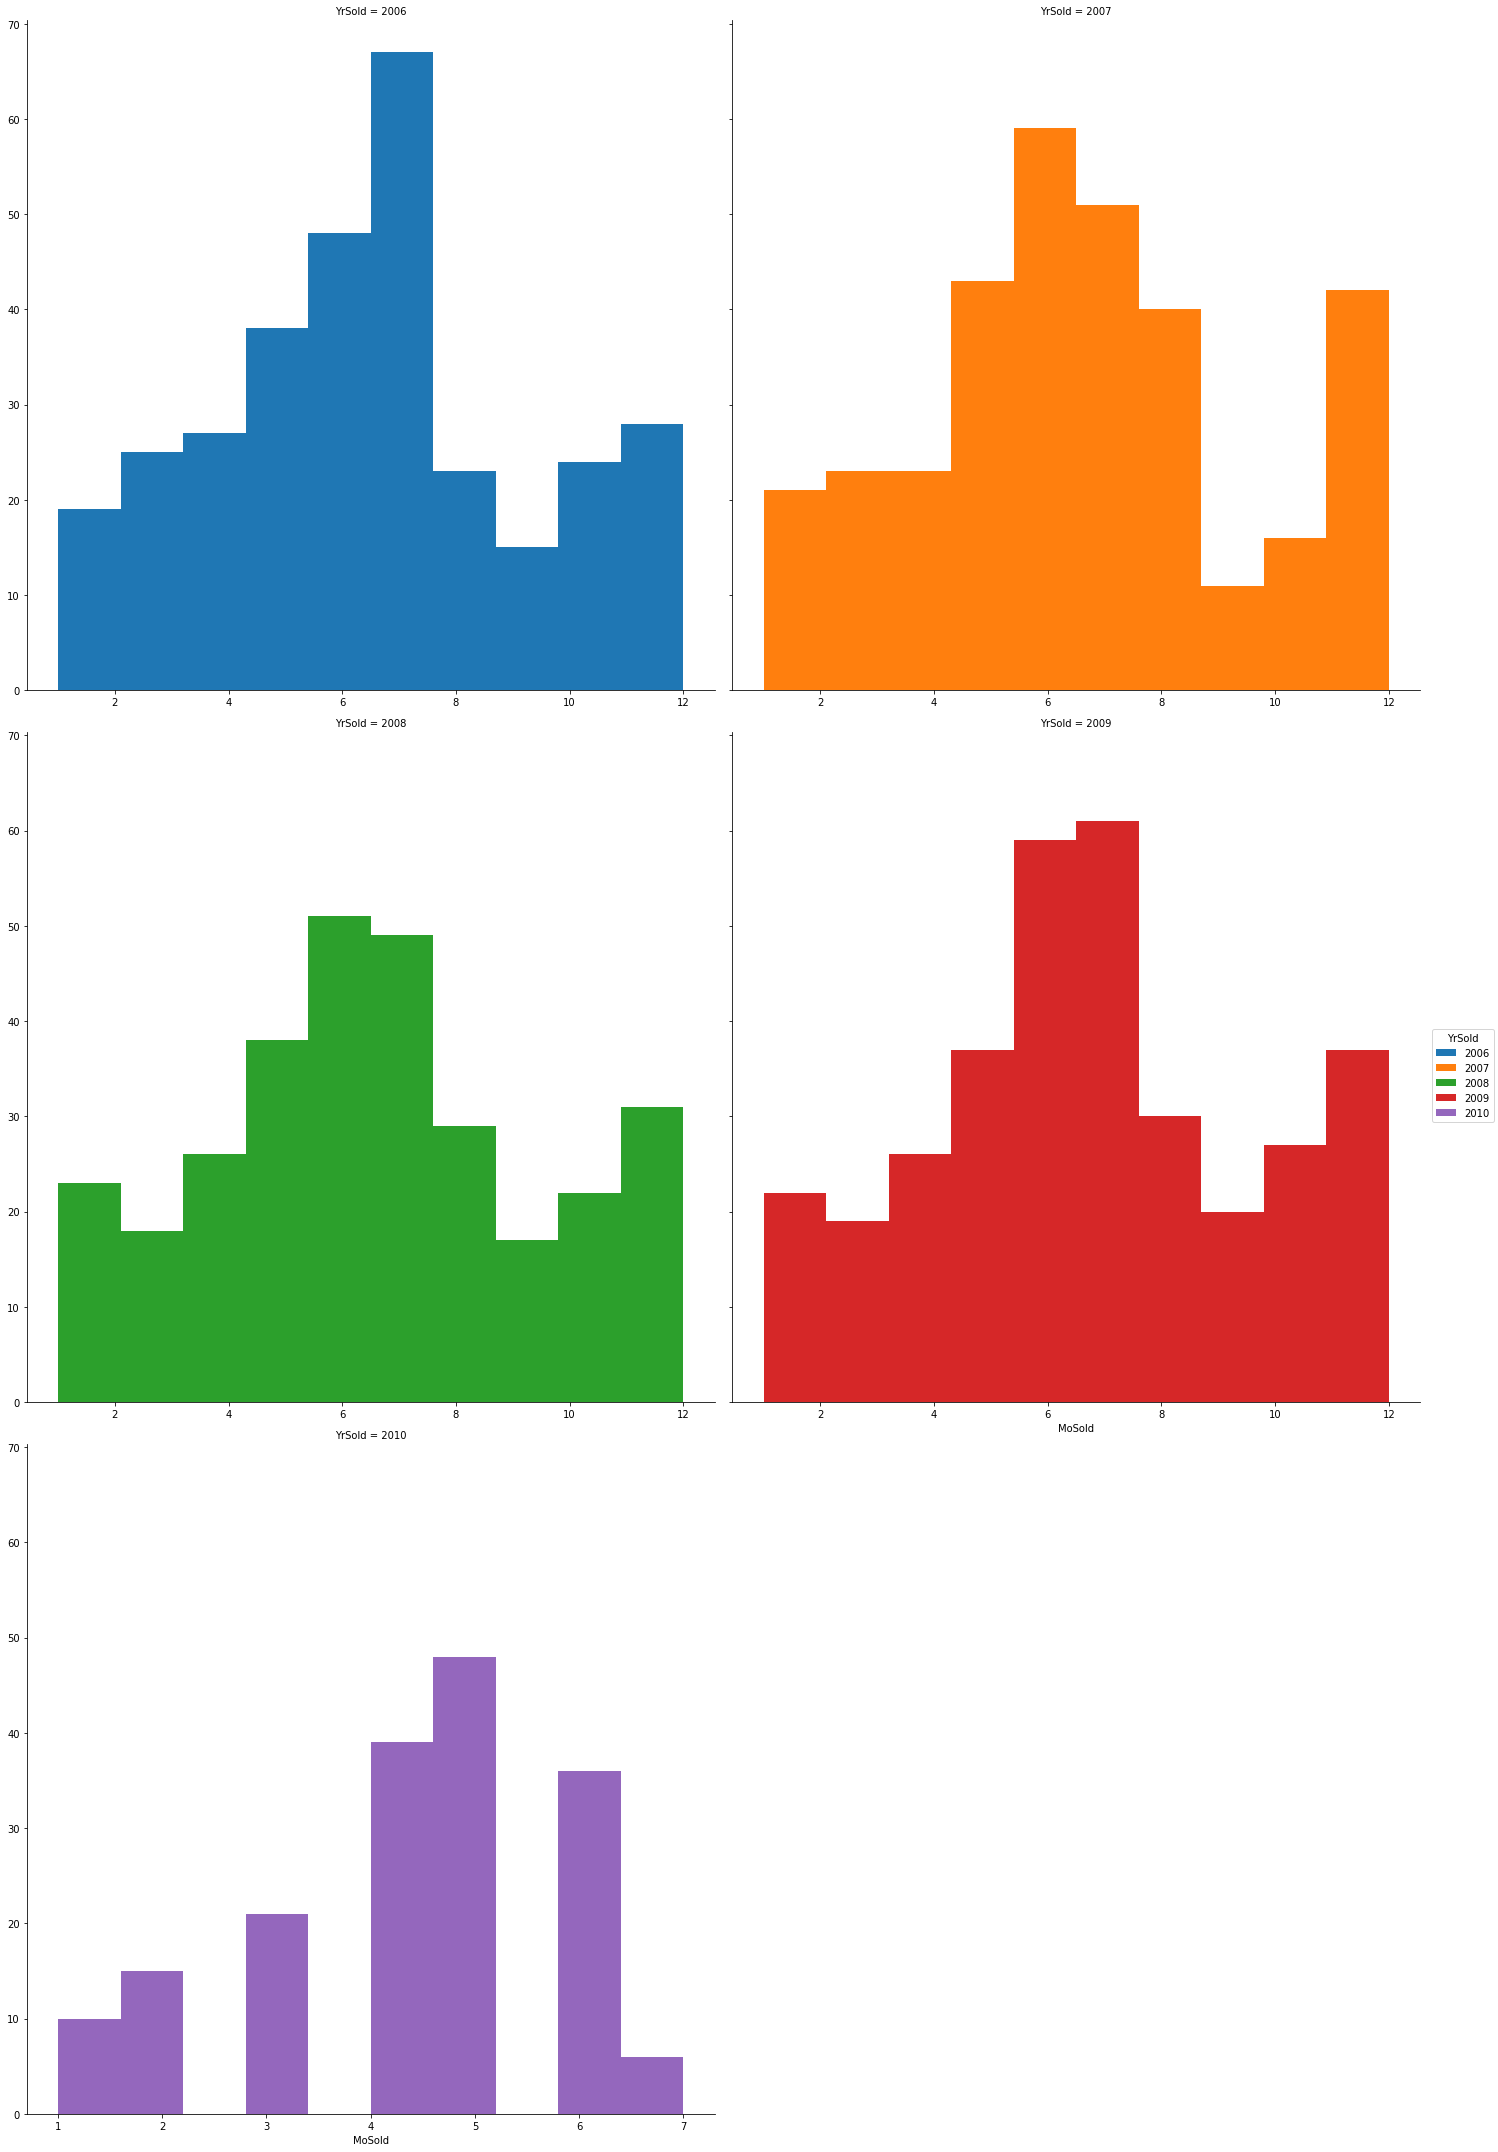

In [73]:
df.sort_values('MoSold')
g = sns.FacetGrid(data, col='YrSold', hue='YrSold', col_wrap=2, sharex=False, sharey=True, size=10)
g.map(plt.hist, 'MoSold').add_legend()

#### In June and July, house tend to sale more as compared to remaining months.

### Lets find total area of the house

In [74]:
data = df.copy()
data['TotalAreaSF'] = data.LotArea + data.GrLivArea + data.GarageArea

In [75]:
data[['TotalAreaSF', 'SalePrice']].corr()

,TotalAreaSF,SalePrice
TotalAreaSF,1.000000,0.308438
SalePrice,0.308438,1.000000


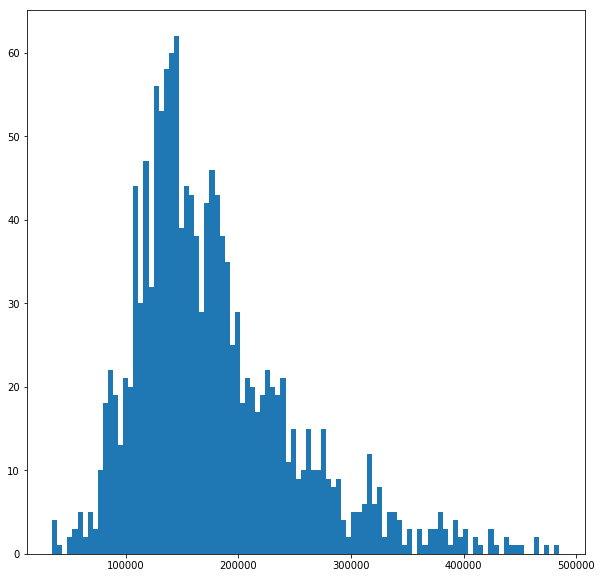

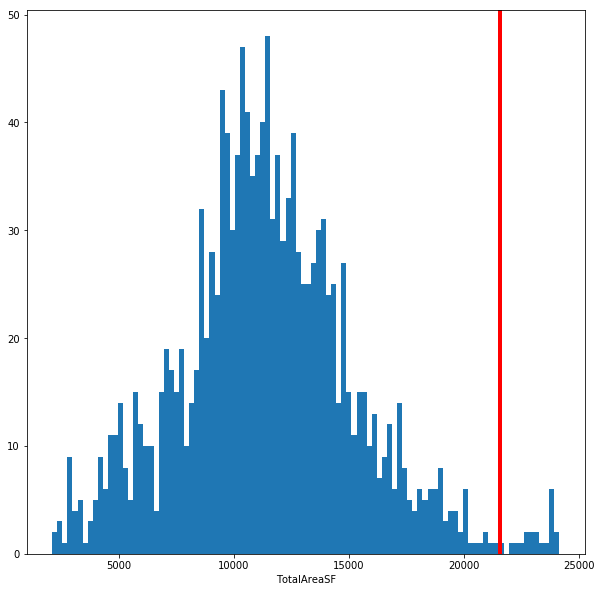

In [76]:
plt.figure(figsize=(10,10))
plt.hist(x = 'SalePrice', data=data[data.SalePrice<500000], bins=100)
plt.figure(figsize=(10,10))
plt.hist(x = 'TotalAreaSF', data=data[data.TotalAreaSF<25000], bins=100)
plt.xlabel('TotalAreaSF')
plt.axvline(x = data.TotalAreaSF.median() + 1*(data.TotalAreaSF.std()),linewidth=4, color='r' )
plt.show()

In [175]:
x = data.copy()
data.TotalAreaSF.mean()+3*(data.TotalAreaSF.std())

43037.979857982777

             TotalAreaSF  SalePrice
TotalAreaSF     1.000000   0.459539
SalePrice       0.459539   1.000000


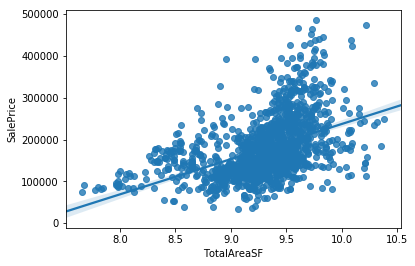

In [194]:
x = data[(data.TotalAreaSF<33000) & (data.SalePrice<500000)].copy()
# x = data[(data.SalePrice<500000)].copy()
# x = data[(data.TotalAreaSF<20000)].copy()
# x['TotalAreaSF'] = np.log(x['TotalAreaSF'])**2
x['TotalAreaSF'] = np.log(x['TotalAreaSF'])
# x['TotalAreaSFNormAL'] = np.log(data['TotalAreaSF'])**2
print(x[['TotalAreaSF', 'SalePrice']].corr())
sns.regplot('TotalAreaSF', 'SalePrice', x)

Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF',
       'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
       'GarageArea', 'n_FireplaceQu', 'n_BsmtQua', 'HouseAge', 'ActualAge',
       'TotalAreaSF'],
      dtype='object')

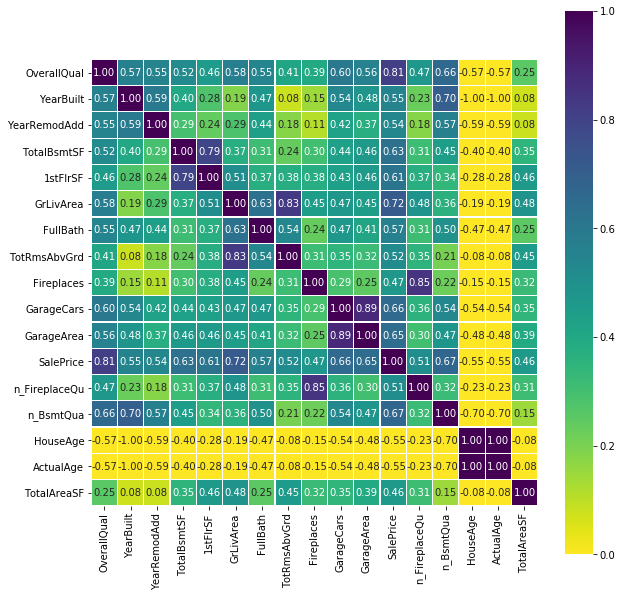

In [195]:
# numfeatures = train.select_dtypes(include=[np.number]).copy()
numfeatures = x.select_dtypes(include=[np.number]).copy()
corr = numfeatures.corr()

#Highly Correlated Features
numfeatures_high_corr = corr[corr.index[(corr['SalePrice']>0.40) | (corr['SalePrice']<-0.4)]].loc[
    corr.index[(corr['SalePrice']>0.40) | (corr['SalePrice']<-0.4)]]

# Heatmap 
plt.figure(figsize=(10,10))
sns.heatmap(numfeatures_high_corr,annot=True,fmt='.2f', 
            vmax=1.0, vmin=0.0,cmap='viridis_r',square=True,annot_kws={"size":10},linewidths=0.1)

highly_corr_features = numfeatures_high_corr.drop('SalePrice').index
del(numfeatures_high_corr)
highly_corr_features

In [281]:
multiregression(x[x.select_dtypes(include=[np.number]).columns.drop(['Id','MSSubClass','SalePrice','ActualAge','YearBuilt','2ndFlrSF','1stFlrSF','TotalBsmtSF','MoYrSold','YrSold','MoSold'])], x['SalePrice'], True)

0.014725527440104795

In [249]:
df = pd.DataFrame(x[x.select_dtypes(include=[np.number]).columns.drop(['Id','MSSubClass','SalePrice','ActualAge','YearBuilt','2ndFlrSF','1stFlrSF','TotalBsmtSF'])].columns)
df['Coef'] = multiregression(x[x.select_dtypes(include=[np.number]).columns.drop(['Id','MSSubClass','SalePrice','ActualAge','YearBuilt','2ndFlrSF','1stFlrSF','TotalBsmtSF'])], x['SalePrice'], True, ReturnModel=True).coef_

In [250]:
df.sort_values(by='Coef', ascending=False)

,0,Coef
34,TotalAreaSF,0.203434
30,n_GarageCond,0.074855
2,OverallQual,0.074156
3,OverallCond,0.050550
12,FullBath,0.040544
13,HalfBath,0.036033
31,n_BsmtQua,0.034716
10,BsmtFullBath,0.032470
17,Fireplaces,0.026978
18,GarageCars,0.022224


In [196]:
multiregression(x[highly_corr_features], x['SalePrice'], True)

0.018071811569295985

In [270]:
features = list(highly_corr_features.drop(['ActualAge','YearBuilt','n_FireplaceQu']).values)
# features.append('n_GarageCond')


In [271]:
multiregression(x[features], x['SalePrice'], True)

0.018065520722776146

In [209]:
df = pd.DataFrame(x[highly_corr_features.drop(['ActualAge','YearBuilt','n_FireplaceQu'])].columns)
df['Coef'] = multiregression(x[highly_corr_features.drop(['ActualAge','YearBuilt','n_FireplaceQu'])], x['SalePrice'], True, ReturnModel=True).coef_

In [210]:
df.sort_values(by='Coef', ascending=False)

,0,Coef
12,TotalAreaSF,0.136494
0,OverallQual,0.085873
7,Fireplaces,0.053514
10,n_BsmtQua,0.023008
8,GarageCars,0.004352
1,YearRemodAdd,0.002714
4,GrLivArea,0.000223
9,GarageArea,0.000202
2,TotalBsmtSF,0.000157
3,1stFlrSF,-0.000026


In [317]:
RemainFeatures = x.select_dtypes(include=[np.number]).columns.drop(['Id','MSSubClass']).drop(highly_corr_features)

             TotalBsmtSF  1stFlrSF
TotalBsmtSF     1.000000  0.890136
1stFlrSF        0.890136  1.000000


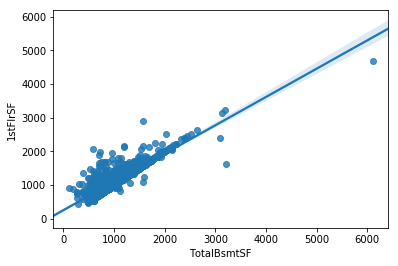

In [443]:
sns.regplot('TotalBsmtSF', '1stFlrSF', train[train.TotalBsmtSF>0])
print(train[train.TotalBsmtSF>0][['TotalBsmtSF', '1stFlrSF']].corr())

,2ndFlrSF,SalePrice
2ndFlrSF,1.000000,0.673305
SalePrice,0.673305,1.000000


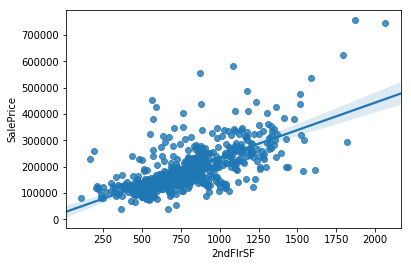

In [463]:
sns.regplot('2ndFlrSF', 'SalePrice', train[train['2ndFlrSF']>0])
train[train['2ndFlrSF']>0][['2ndFlrSF', 'SalePrice']].corr()

In [473]:
x['Is2ndFlr'] = train['2ndFlrSF'].apply(lambda x: 1 if x>0 else 0)

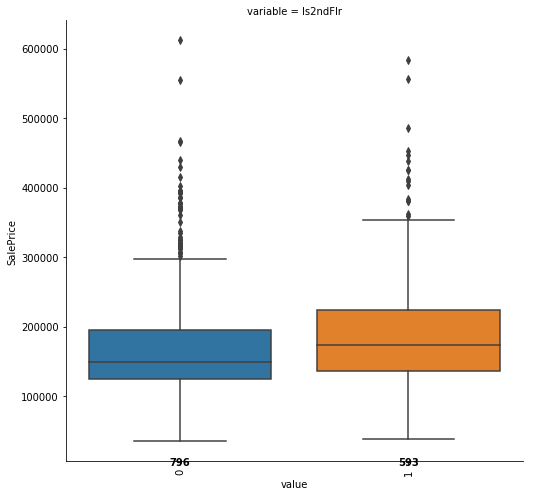

In [474]:
sp.boxplot('Is2ndFlr', 'SalePrice', x)

#### drop 2ndFlrSF feature.

In [321]:
RemainFeatures = RemainFeatures.drop(['YrSold', 'MoSold', 'PoolArea', 'LotArea', 'LotFrontage','SalePrice','MoYrSold','2ndFlrSF'])

In [322]:
RemainFeatures.tolist()

['OverallCond',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'LowQualFinSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'MiscVal',
 'n_GarageCond']

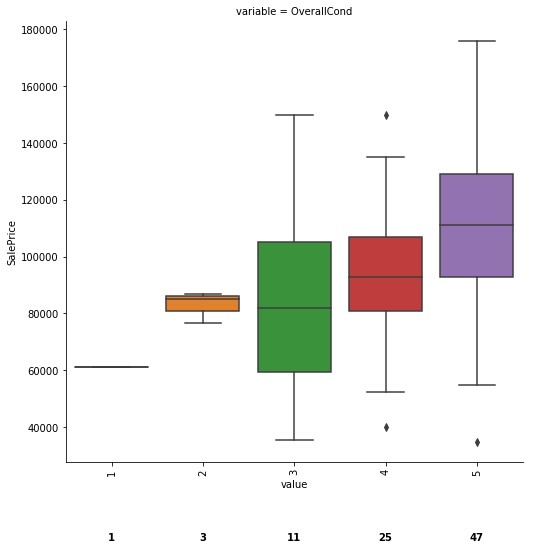

In [349]:
sp.boxplot('OverallCond',  'SalePrice',x[(x['OverallQual']<5) & (x['OverallCond']<6)])

In [334]:
pd.crosstab(x['OverallCond'], x['OverallQual'], x['Id'], aggfunc='count')

OverallQual,1,2,3,4,5,6,7,8,9,10
OverallCond,,,,,,,,,,
1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,2.0,1.0,1.0,NaN,NaN,NaN,1.0,NaN
3,1.0,2.0,3.0,5.0,7.0,5.0,1.0,NaN,NaN,NaN
4,NaN,NaN,6.0,19.0,20.0,6.0,3.0,1.0,NaN,NaN
5,NaN,1.0,2.0,44.0,139.0,178.0,244.0,147.0,37.0,10.0
6,NaN,NaN,5.0,23.0,103.0,83.0,28.0,7.0,NaN,NaN
7,NaN,NaN,1.0,19.0,89.0,65.0,22.0,6.0,NaN,NaN
8,NaN,NaN,1.0,2.0,29.0,29.0,8.0,2.0,NaN,NaN
9,NaN,NaN,NaN,1.0,4.0,3.0,9.0,3.0,NaN,2.0


# Categorical Features 

In [86]:
# sp.boxplot(catfeatures.columns, 'SalePrice', train)

# Data Modeling

In [65]:
def multiregression(features, target, log_y=False, TrainTestSplit=True, TestSize=0.33, MSE = True, ReturnModel=False):
    
    if sum(features.isnull().sum())>0:
        return(ValueError('Data contains NULL values'))
    
    if log_y == True:
        target = np.log(target)
    
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_squared_error
    regr = LinearRegression()

    
    if TrainTestSplit==True:
        x_train, x_test, y_train, y_test = train_test_split(features, target, random_state=42, test_size=TestSize)
        
    else:
        x_train = features
        y_train = target
        x_test = features
        y_test = target
        
    model = regr.fit(x_train, y_train)
    predict = model.predict(x_test)
    
    
    
    
    if ReturnModel==True:
        return(model)
    elif MSE==True:
        return(mean_squared_error(y_test, predict))
    else:
        return(predict)


In [53]:
multiregression(train[numfeatures.columns.drop(['SalePrice'])], train['SalePrice'], True, True, 0.2)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


0.02282818724917627

In [54]:
multiregression(train[numfeatures.columns.drop(['SalePrice','n_BsmtQua'])], train['SalePrice'], True, True, 0.2)

0.022573505973043494

In [55]:
multiregression(train[highly_corr_features], train['SalePrice'], True, True, 0.2)

0.02850654927006337

In [56]:
multiregression(train[highly_corr_features.drop('n_BsmtQua')], train['SalePrice'], True, True, 0.2)

0.028127686720982308

In [57]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train[numfeatures.columns.drop('SalePrice')], train['SalePrice'], random_state=42, test_size=0.33)

In [58]:
len(x_test)

482

In [59]:
df = train[numfeatures.columns].copy()

df_f1 = pd.merge(df, pd.get_dummies(train.n_BsmtQua, drop_first=True, prefix='BsmtQua'),  left_index=True, right_index=True)
df_f2 = pd.merge(df_f1,pd.get_dummies(train.Neighborhood, drop_first=True, prefix='NB'), how='inner', left_index=True, right_index=True)
df_f3 = pd.merge(df_f2,pd.get_dummies(train.HouseStyle, drop_first=True, prefix='HS'), how='inner', left_index=True, right_index=True)
df_f4 = pd.merge(df_f3,pd.get_dummies(train.MSZoning, drop_first=True, prefix='Zone'), how='inner', left_index=True, right_index=True)
df_f5 = pd.merge(df_f4,pd.get_dummies(train.ExterCond, drop_first=True, prefix='Exter'), how='inner', left_index=True, right_index=True)
df_final = pd.merge(df_f5,pd.get_dummies(train.KitchenQual, drop_first=True, prefix='Kitchen'), how='inner', left_index=True, right_index=True)
# df_final = pd.merge(df_f6,pd.get_dummies(train.MSSubClass, drop_first=True, prefix='CentralAir'), how='inner', left_index=True, right_index=True)

In [60]:
multiregression(df_final.drop(['SalePrice','n_BsmtQua','BsmtQua_3','OverallCond'], axis=1), df_final['SalePrice'], True, True, 0.2)

0.018181238068974488

In [61]:
train[low_corr_features].isnull().sum().head()

LotArea        0
OverallCond    0
BsmtFinSF1     0
BsmtFinSF2     0
BsmtUnfSF      0
dtype: int64

In [62]:
# train[low_corr_features].isnull().sum().sort_values(ascending=False)
# test_data = train.copy()
# test_data['IsLotFrontage'] = test_data['LotFrontage'].isnull()
# test_data.hist('SalePrice',bins=30, by='IsLotFrontage', figsize=(15,8))

In [63]:
data_copy = train.LotFrontage.interpolate()
data_copy.name = 'LotFrontage'
print(data_copy.head())
# data_copy['IsLotFrontage'] = pd.concat(train.LotFrontage.isnull(), data_copy['LotFrontage'])
# data_copy.head()

AttributeError: 'DataFrame' object has no attribute 'LotFrontage'

In [ ]:
# f = pd.melt(numfeatures,
#         id_vars=['SalePrice'], 
#         value_vars=highly_corr_features)
# g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=True, size=5)
# g = g.map(sns.regplot, "value", "SalePrice", scatter_kws={"alpha":0.5,"s":50})

As we can see in the HeatMap, GarageArea and GarageCars has 0.88 correlation coefficient. Now, wea are going to dig in to do some feature engineering.

In [ ]:
train.MSSubClass.value_counts(dropna=False).sort_index().sum()
df = train.copy()
bins = [0, 1900, 1995, 2000, 2005, 2010]
df['YrBuilt_bins']=pd.cut(df['YearBuilt'], bins)

In [ ]:
pd.crosstab(index=train['Foundation'], columns=train['BsmtQual'], values=train['Id'], aggfunc='count')

# Building Model

### Spliting Data Set  

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
feats = highly_corr_features.tolist()
# feats.append('MSSubClass')
feats.remove('MasVnrArea')
feats.remove('GarageYrBlt')

In [ ]:
data = train.copy()
categorical.columns

In [ ]:
# train['enc_neighborhood']=
# pd.get_dummies(train.Neighborhood, drop_first=True)
final = pd.merge(data,pd.get_dummies(train.Neighborhood, drop_first=True), how='inner', left_index=True, right_index=True)
# train.Neighborhood.value_counts().sort_values(ascending=False)

In [ ]:
# feats = numfeatures.drop(['SalePrice','GarageYrBlt','LotFrontage','MasVnrArea'], axis=1).columns.tolist()
# feats = feats + pd.get_dummies(train.Neighborhood, drop_first=True).columns.tolist()
# feats
data[feats].isnull().sum()

In [ ]:
sum(final[feats].isnull().sum().sort_values(ascending=False))
final[feats].isnull().sum()

In [ ]:
y = np.log(data.SalePrice)
x = data[feats]
x_train, x_test, y_train, y_test = train_test_split(x,y,
                                                   random_state = 42,
                                                   test_size = 0.33)

In [ ]:
regr = LinearRegression()
model = regr.fit(x_train, y_train)

In [ ]:
# feats = test[highly_corr_features].interpolate()

In [ ]:
predict = model.predict(x_test)

In [ ]:
mean_squared_error(y_test, predict)

In [ ]:
regr.coef_

### Cross Validation 

In [ ]:
from sklearn import cross_validation
x = df_final.drop('SalePrice', axis=1)
y = np.log(df_final['SalePrice'])

In [ ]:
cv = cross_validation.KFold(len(x), n_folds=20)

In [ ]:
regr = LinearRegression()
result=[]
for traincv, testcv in cv:
    probs = regr.fit(x.loc[traincv], y.loc[traincv]).predict(x.loc[testcv])
    result.append(mean_squared_error(y.loc[testcv],probs)**0.5)

In [ ]:
result.sort()
result

In [ ]:
test=final.copy()
test = test.interpolate()

In [ ]:
test=pd.get_dummies(test,drop_first=True)
test.shape

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=10)

In [ ]:
pca.fit(test)

In [ ]:
np.cumsum(pca.explained_variance_ratio_)

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))